In [52]:
import requests
import io
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

In [31]:
df = pd.read_csv('AMZN_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [32]:
df.index = pd.to_datetime(df.index)

In [33]:
corrs = df.corr().stack().reset_index()
corrs.columns = ['1','2','R2']
temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
correlations = temp[temp.index % 2 == 0]

In [34]:
correlations['1'].value_counts()

RSI_oversold_cross    1
Name: 1, dtype: int64

In [35]:
X = df.shift(1).dropna()
y = df['day_direction'].iloc[1:]

In [36]:
train_num = round(len(X)*.8)
test_num = round(len(X)*.2)
print(train_num, test_num)

1798 450


In [37]:
X_train = X.iloc[:train_num]
X_test = X.iloc[-test_num:]
y_train = y.iloc[:train_num]
y_test = y.iloc[-test_num:]

In [38]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [39]:
X_train_scaled.columns

Index(['low', 'open', 'volume', 'high', 'close', 'adjustedclose', 'rsi',
       'BBB_5_2.0', 'BBP_5_2.0', 'ema7', 'day_direction',
       'golden_crossover_short', 'death_crossover_short',
       'golden_crossover_long', 'death_crossover_long', 'RSI_overbought_cross',
       'RSI_oversold_cross', 'RSI_overbought', 'RSI_oversold', 'momentum',
       'psr', 'ir', 'ffer', 'sp500_return', 'sp500_BBB_5_2.0',
       'sp500_BBP_5_2.0'],
      dtype='object')

In [40]:
def logreg(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2' ,'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(random_state=42)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv,
                      scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    logreg_params = gs.best_params_
    
    # Use best penalty from best_params
    logreg_penalty = logreg_params['penalty']
    print(f'Penalty: {logreg_penalty}')
    
    # Use best solver from best_params
    logreg_solver = logreg_params['solver']
    print(f'Solver: {logreg_solver}')
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
  
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 Score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)

Penalty: l1
Solver: saga
Mean Cross-Val Score: 0.518373568554627
Train Mean Accuracy: 0.5372636262513905
Test Mean Accuracy: 0.4711111111111111
Recall Score: 0.037037037037037035
Precision Score: 0.6923076923076923
F1 Score: 0.0703125


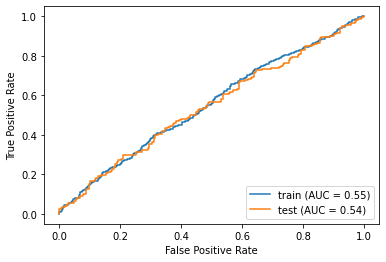

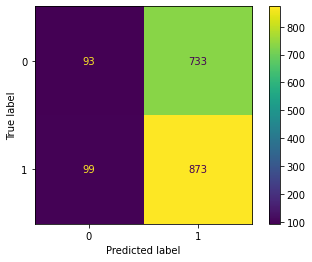

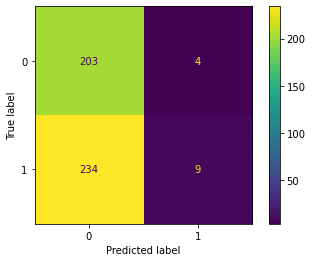

In [41]:
logreg(X_train_scaled, X_test_scaled, y_train, y_test)

In [42]:
def dtree(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_depth': [3,10,15],
    'min_samples_split': [2,8,10,15],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Decision Tree model for GridSearch
    grid_dt = DecisionTreeClassifier()
    grid_dt.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_dt, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    dt_params = gs.best_params_
    
    # Use best max depth from best_params
    dt_max_depth = dt_params['max_depth']
    print(f'Max Depth: {dt_max_depth}')
    
    # Use best minimum sample split from best_params
    dt_min_samp = dt_params['min_samples_split']
    print(f'Min Sample Split: {dt_min_samp}')
    
    # Use best criterion from best_params
    dt_criterion = dt_params['criterion']
    print(f'criterion: {dt_criterion}')
    
    # Instantiate & fit Decision Tree model (don't need to do this)
   # dtree = DecisionTreeClassifier(max_depth=dt_max_depth, criterion=dt_criterion,
           #                        min_samples_split=dt_min_samp, random_state=42)
    #dtree.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)

Max Depth: 3
Min Sample Split: 8
criterion: gini
Mean Cross-Val Score: 0.4933147632311978
Train Mean Accuracy: 0.5456062291434928
Test Mean Accuracy: 0.5333333333333333
Recall Score: 0.9382716049382716
Precision Score: 0.5390070921985816
F1 score: 0.6846846846846846


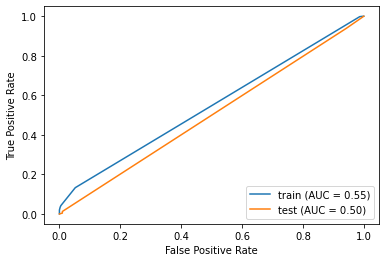

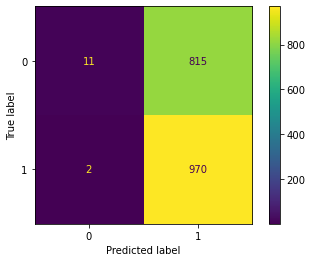

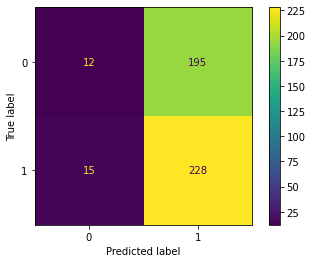

In [43]:
dtree(X_train,X_test,y_train,y_test)

In [44]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
def random_forest(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'n_estimators': [75,90,100,110,115,125,150,500],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Random Forest model for GridSearch
    grid_rf = RandomForestClassifier()
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_rf, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    rf_params = gs.best_params_
    
    # Use best # of trees from best_params
    rf_n_estimators = rf_params['n_estimators']
    print(f'Number of Trees: {rf_n_estimators}')
    
    # Use best criterion from best_params
    rf_criterion = rf_params['criterion']
    print(f'Criterion: {rf_criterion}')
    
    # Instantiate & fit Random Forest model(don't need to do this)
    #rforest = RandomForestClassifier(n_estimators=rf_n_estimators, criterion=rf_criterion,
                                   # random_state=42)
   # rforest.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Test Mean Accuracy: {test_score}')
    
    rec_score = recall_score(y_test, y_pred)
    print(f'Recall Score: {rec_score}')
    
    prec_score = precision_score(y_test, y_pred)
    print(f'Precision Score: {prec_score}')
    
    f1 = f1_score(y_test, y_pred)
    print(f'F1 score: {f1}')
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test);


In [45]:
#random_forest(X_train, X_test, y_train, y_test)

In [46]:
def xgboost(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'learning_rate': [.01,.05,.1,.5,1],
    'max_depth': [4],
    'min_child_weight': [3],
    'subsample': [1],
    'n_estimators': [100,500]}
    
    # Instantiate & fit XGClassifier
    xgb = XGBClassifier(verbosity=0, random_state=42)
    #xgb.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=xgb, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    xgb_params = gs.best_params_
    
    # Use best learning rate from best_params
    xgb_lr = xgb_params['learning_rate']
    print(f'XGBoost Learning Rate: {xgb_lr}')
    
    # Use best max depth from best_params
    xgb_max_depth = xgb_params['max_depth']
    print(f'XGBoost Max Depth: {xgb_max_depth}')
    
    # Use best min child weight from best_params
    xgb_min_child_weight = xgb_params['min_child_weight']
    print(f'XGBoost Min Child Weight: {xgb_min_child_weight}')
    
    # Use best subsample from best_params
    xgb_subsample = xgb_params['subsample']
    print(f'XGBoost Subsample: {xgb_subsample}')
    
    # Use best estimators from best_params
    xgb_estimators = xgb_params['n_estimators']
    print(f'XGBoost Estimators: {xgb_estimators}')
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test);

XGBoost Learning Rate: 0.01
XGBoost Max Depth: 4
XGBoost Min Child Weight: 3
XGBoost Subsample: 1
XGBoost Estimators: 100
Mean Cross-Val Score: 0.49275920767564224
Train Mean Accuracy Score: 0.6245828698553949
Test Mean Accuracy Score: 0.48


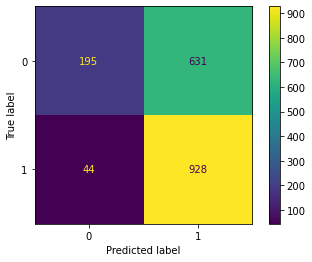

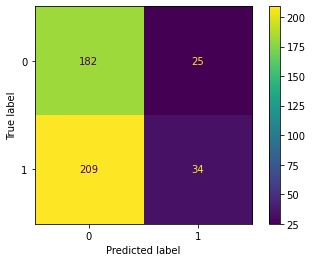

In [47]:
xgboost(X_train_scaled, X_test_scaled, y_train, y_test)

In [50]:
def Linear_SVC(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    }
    
    # Instantiate & fit XGClassifier
    svc = LinearSVC(random_state=42, max_iter = 10e5)
    #xgb.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=svc, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    svc_params = gs.best_params_
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    print(f'Train Mean Accuracy Score: {train_score}')
    test_score = gs.score(X_test, y_test)
    print(f'Test Mean Accuracy Score: {test_score}')
    
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test);

Mean Cross-Val Score: 0.5289229340761373
Train Mean Accuracy Score: 0.5417130144605117
Test Mean Accuracy Score: 0.54


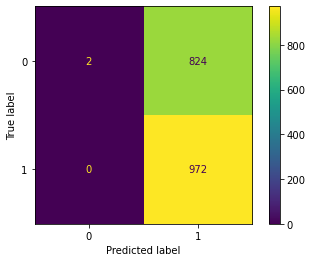

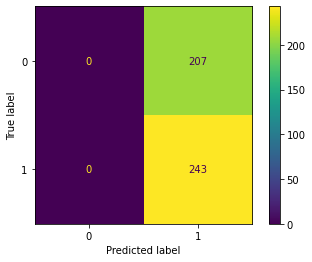

In [53]:
Linear_SVC(X_train_scaled, X_test_scaled, y_train, y_test)